In [1]:
from functions_for_all_nutrients import *
from vitamin_a_and_zinc_functions import *

In [2]:
# Get absolute path of repo based on relative directory structure, so it should work for all users
import os.path
vivarium_research_lsff_path = os.path.abspath("..")
vivarium_research_lsff_path

'/ihme/homes/alibow/notebooks/vivarium_research_lsff'

In [3]:
username = !whoami
username

['alibow']

In [4]:
# Specify directory with saved GBD data so that it's not necessary to call get_draws on every run.

# Nathaniel has saved some .hdf files in this directory on /share
# You can specify a different directory if you have GBD data saved somewhere else.
# Or if you want to re-pull the data, you can change this to a nonexistent directory.
gbd_data_directory = '/share/scratch/users/ndbs/vivarium_lsff/gbd_data'
gbd_data_filepath = f'{gbd_data_directory}/multmodel_data.hdf'

In [5]:
index_cols=['location_id','sex_id','age_group_id']
age_group_ids = [2,3,4,5]
sex_ids = [1,2]
coverage_levels = [0.2,0.5,0.8]
years = [2021,2022,2023,2024,2025]

In [6]:
coverage_data_dir = vivarium_research_lsff_path + '/data_prep/outputs/lsff_input_coverage_data.csv'
# # Old version that may not work for all users:
# coverage_data_dir = f'/ihme/homes/{username[0]}/notebooks/' \
#     'vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [7]:
location_ids = (list(
                pd.read_csv(coverage_data_dir)
                .location_id
                .unique()))
location_ids

[161,
 201,
 202,
 205,
 171,
 179,
 163,
 11,
 180,
 184,
 15,
 164,
 214,
 165,
 196,
 190,
 189,
 20]

# VITAMIN A

In [8]:
# vitamin A specific -- these should be replaced for other models
rei_id = 96
nutrient = 'vitamin a'
vehicles = ['oil']
effective_fractions = [0, 0, (365 - (365 * 0.5)) / (365 - 28), 1]

In [9]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 2.22
q_975 = 5.26

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)b
rr_distribution = lognorm(s=sigma, scale=median)

In [10]:
vitamin_a_baseline_coverage, vitamin_a_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             nutrient,
                                             vehicles,
                                             years,
                                             coverage_levels)

In [12]:
vitamin_a_baseline_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_baseline_coverage.set_index(['location_id','year','vehicle']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)
vitamin_a_counterfactual_effective_coverage = get_effective_vitamin_a_coverage(vitamin_a_counterfactual_coverage.set_index(['location_id','year','vehicle','coverage_level']), 
                                                               sex_ids,
                                                               age_group_ids,
                                                               effective_fractions,
                                                               years)

In [13]:
vitamin_a_rr_deficiency_nofort = generate_rr_deficiency_nofort_draws(mu, sigma, location_ids)
vitamin_a_rr_deficiency_nofort.mean(axis=1)

location_id
161    2.396239
201    2.396239
202    2.396239
205    2.396239
171    2.396239
179    2.396239
163    2.396239
11     2.396239
180    2.396239
184    2.396239
15     2.396239
164    2.396239
214    2.396239
165    2.396239
196    2.396239
190    2.396239
189    2.396239
20     2.396239
dtype: float64

In [14]:
vitamin_a_dalys_hdf_key = '/vitamin_a_deficiency/dalys_attributable_bmgf_25_countries'
try:
    vitamin_a_dalys = pd.read_hdf(gbd_data_filepath, key=vitamin_a_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    vitamin_a_dalys = pull_deficiency_attributable_dalys(rei_id,
                                                  location_ids,
                                                  age_group_ids,
                                                  sex_ids,
                                                  index_cols)
else:
    # Stored data included all 25 locations, so filter to desired locations if try clause succeeded
    vitamin_a_dalys = vitamin_a_dalys.query("location_id in @location_ids")

vitamin_a_dalys.head()

draw_0        draw_1      draw_10  \
location_id sex_id age_group_id                                           
11          1      2               15.643974     11.649047    10.702306   
                   3              416.873698     53.322352   237.666914   
                   4             5454.716037  11143.888952  3942.141084   
                   5             7061.863832  12302.987822  6718.774713   
            2      2                1.549269      0.404984     3.379241   

                                     draw_100     draw_101     draw_102  \
location_id sex_id age_group_id                                           
11          1      2                22.432649    20.202105     2.212762   
                   3               526.237873   213.814078   238.233821   
                   4             20712.552520  1959.269695  2593.831344   
                   5             10783.411036  5366.467986  4331.269326   
            2      2                 0.357472     0.775833     0.476560   

                                    draw_103      draw_104     draw_105  \
location_id sex_id age_group_id                                           
11          1      2               15.114881      2.892967    21.084614   
                   3              292.861711    234.522352   205.527553   
                   4             2243.574895   6456.947129  4188.536919   
                   5             4137.341476  11124.779258  9288.936088   
            2      2                0.743103      0.246415     0.707546   

                                    draw_106  ...     draw_990      draw_991  \
location_id sex_id age_group_id               ...                              
11          1      2                3.269923  ...     4.459072      9.992524   
                   3              104.225482  ...   319.517030    155.820635   
                   4             9025.398940  ...  4054.138549   8481.152070   
                   5             6737.690066  ...  8306.577325  11941.064285   
            2      2                0.844587  ...     0.626792      0.356775   

                                     draw_992      draw_993      draw_994  \
location_id sex_id age_group_id                                             
11          1      2                 6.246982      9.818640     10.360898   
                   3               163.410724    118.107240     56.805845   
                   4              8550.310159   7408.158676   5497.640171   
                   5             18457.827148  13000.390250  12079.012612   
            2      2                 0.108020      0.444195      0.136628   

                                    draw_995     draw_996     draw_997  \
location_id sex_id age_group_id                                          
11          1      2               11.749518    11.033684    17.614170   
                   3              531.685997   114.365595    67.014103   
                   4             3215.251128  4809.325159  3776.728264   
                   5             5268.298325  4227.467383  4695.034382   
            2      2                0.210050     0.086950     0.621272   

                                    draw_998     draw_999  
location_id sex_id age_group_id                            
11          1      2                5.405180     7.109480  
                   3              167.893939   320.609374  
                   4             6111.980137  3686.224482  
                   5             8901.482649  4631.831861  
            2      2                0.288802     0.115681  

[5 rows x 1000 columns]

In [15]:
vitamin_a_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    vitamin_a_rr_deficiency_nofort, 
                                    vitamin_a_baseline_effective_coverage)
vitamin_a_paf_deficiency_nofort.head()

draws                                          draw_0    draw_1   draw_10  \
location_id sex_id age_group_id year vehicle                                
11          1      2            2021 oil      0.78595  0.447022  0.406811   
                                2022 oil      0.78595  0.447022  0.406811   
                                2023 oil      0.78595  0.447022  0.406811   
                                2024 oil      0.78595  0.447022  0.406811   
                                2025 oil      0.78595  0.447022  0.406811   

draws                                         draw_100  draw_101  draw_102  \
location_id sex_id age_group_id year vehicle                                 
11          1      2            2021 oil      0.340996  0.617978  0.620854   
                                2022 oil      0.340996  0.617978  0.620854   
                                2023 oil      0.340996  0.617978  0.620854   
                                2024 oil      0.340996  0.617978  0.620854   
                                2025 oil      0.340996  0.617978  0.620854   

draws                                         draw_103  draw_104  draw_105  \
location_id sex_id age_group_id year vehicle                                 
11          1      2            2021 oil      0.149863  0.636347  0.421241   
                                2022 oil      0.149863  0.636347  0.421241   
                                2023 oil      0.149863  0.636347  0.421241   
                                2024 oil      0.149863  0.636347  0.421241   
                                2025 oil      0.149863  0.636347  0.421241   

draws                                         draw_106  ...  draw_990  \
location_id sex_id age_group_id year vehicle            ...             
11          1      2            2021 oil      0.759597  ...  0.507946   
                                2022 oil      0.759597  ...  0.507946   
                                2023 oil      0.759597  ...  0.507946   
                                2024 oil      0.759597  ...  0.507946   
                                2025 oil      0.759597  ...  0.507946   

draws                                         draw_991  draw_992  draw_993  \
location_id sex_id age_group_id year vehicle                                 
11          1      2            2021 oil      0.455066  0.740104  0.785748   
                                2022 oil      0.455066  0.740104  0.785748   
                                2023 oil      0.455066  0.740104  0.785748   
                                2024 oil      0.455066  0.740104  0.785748   
                                2025 oil      0.455066  0.740104  0.785748   

draws                                         draw_994  draw_995  draw_996  \
location_id sex_id age_group_id year vehicle                                 
11          1      2            2021 oil      0.396677  0.557149   0.64751   
                                2022 oil      0.396677  0.557149   0.64751   
                                2023 oil      0.396677  0.557149   0.64751   
                                2024 oil      0.396677  0.557149   0.64751   
                                2025 oil      0.396677  0.557149   0.64751   

draws                                         draw_997  draw_998  draw_999  
location_id sex_id age_group_id year vehicle                                
11          1      2            2021 oil      0.441514  0.406003  0.393076  
                                2022 oil      0.441514  0.406003  0.393076  
                                2023 oil      0.441514  0.406003  0.393076  
                                2024 oil      0.441514  0.406003  0.393076  
                                2025 oil      0.441514  0.406003  0.393076  

[5 rows x 1000 columns]

In [16]:
vitamin_a_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    vitamin_a_paf_deficiency_nofort,
                                    vitamin_a_baseline_effective_coverage,
                                    vitamin_a_counterfactual_effective_coverage)
vitamin_a_pif_deficiency_nofort.head()

draws                                                        draw_0  draw_1  \
location_id sex_id age_group_id year vehicle coverage_level                   
11          1      2            2021 oil     0.2                0.0     0.0   
                                             0.5                0.0     0.0   
                                             0.8                0.0     0.0   
                                2022 oil     0.2                0.0     0.0   
                                             0.5                0.0     0.0   

draws                                                        draw_10  \
location_id sex_id age_group_id year vehicle coverage_level            
11          1      2            2021 oil     0.2                 0.0   
                                             0.5                 0.0   
                                             0.8                 0.0   
                                2022 oil     0.2                 0.0   
                                             0.5                 0.0   

draws                                                        draw_100  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_101  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_102  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_103  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_104  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                                2022 oil     0.2                  0.0   
                                             0.5                  0.0   

draws                                                        draw_105  \
location_id sex_id age_group_id year vehicle coverage_level             
11          1      2            2021 oil     0.2                  0.0   
                                             0.5                  0.0   
                                             0.8                  0.0   
                

In [17]:
vitamin_a_overall_pifs, vitamin_a_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    vitamin_a_pif_deficiency_nofort,
                                                    vitamin_a_dalys,
                                                    coverage_levels, years)

In [18]:
vitamin_a_daly_reduction_rates = calculate_rates(vitamin_a_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [19]:
vitamin_a_overall_pifs['measure'] = 'pif'
vitamin_a_daly_reduction_counts['measure'] = 'counts_averted'
vitamin_a_daly_reduction_rates['measure'] = 'rates_averted'
vitamin_a_results = pd.concat([vitamin_a_overall_pifs.reset_index(),
                         vitamin_a_daly_reduction_counts.reset_index(),
                         vitamin_a_daly_reduction_rates.reset_index()],
                        ignore_index=True)
vitamin_a_results.to_pickle('results_raw/vitamin_a.pkl')
vitamin_a_results

draws,location_id,year,vehicle,coverage_level,draw_0,draw_1,draw_10,draw_100,draw_101,draw_102,...,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999,measure
0,11,2021,oil,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
1,11,2021,oil,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
2,11,2021,oil,0.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,pif
3,11,2022,oil,0.2,3.557247,1.873075,1.769045,1.292221,2.926811,2.936429,...,1.993341,3.638718,3.671240,1.762281,2.481137,2.857787,1.916171,1.744613,1.719472,pif
4,11,2022,oil,0.5,8.893116,4.682687,4.422612,3.230552,7.317027,7.341072,...,4.983353,9.096794,9.178100,4.405702,6.202842,7.144468,4.790429,4.361533,4.298679,pif
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,214,2024,oil,0.5,54.720265,57.120811,18.619447,33.331208,12.266424,17.818214,...,29.987143,70.852450,45.647860,38.928796,26.169200,22.486807,26.832144,25.469602,9.729985,rates_averted
806,214,2024,oil,0.8,87.552424,91.393297,29.791115,53.329933,19.626278,28.509143,...,47.979429,113.363919,73.036575,62.286073,41.870720,35.978891,42.931430,40.751363,15.567975,rates_averted
807,214,2025,oil,0.2,21.888106,22.848324,7.447779,13.332483,4.906569,7.127286,...,11.994857,28.340980,18.259144,15.571518,10.467680,8.994723,10.732858,10.187841,3.891994,rates_averted
808,214,2025,oil,0.5,54.720265,57.120811,18.619447,33.331208,12.266424,17.818214,...,29.987143,70.852450,45.647860,38.928796,26.169200,22.486807,26.832144,25.469602,9.729985,rates_averted


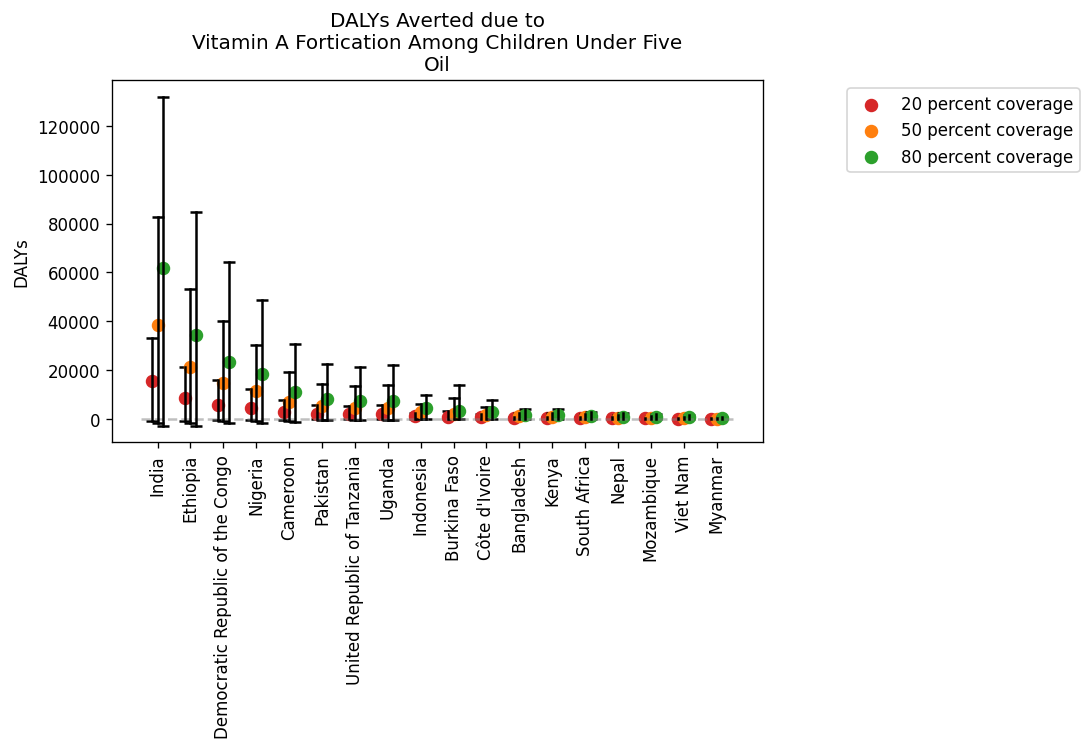

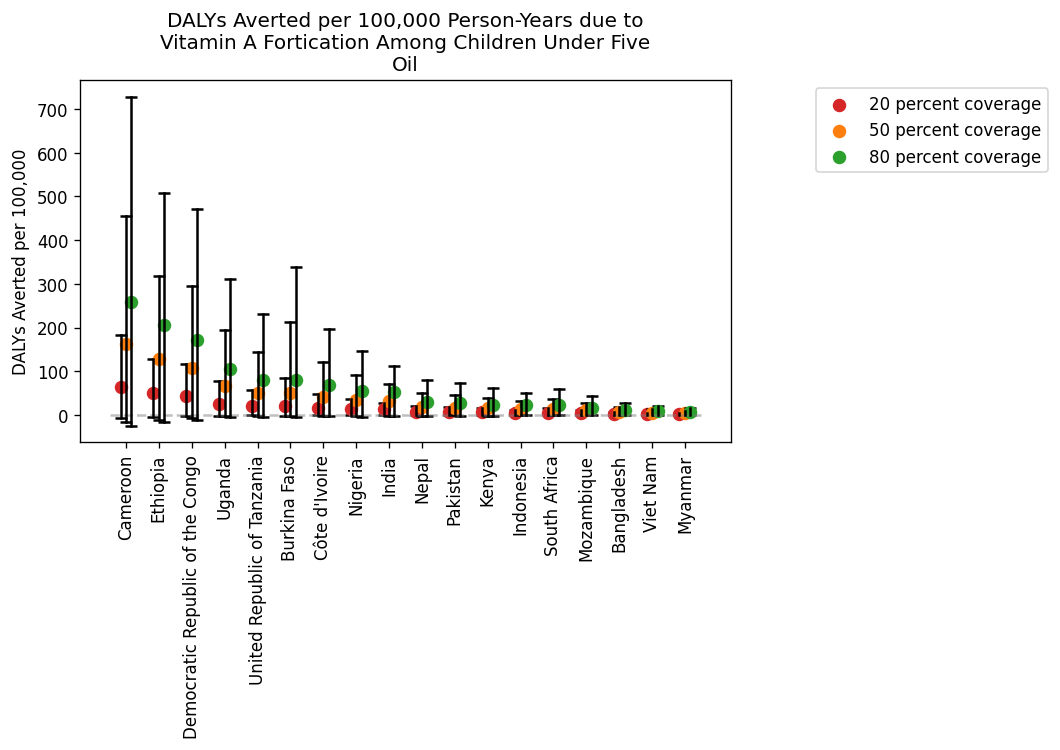

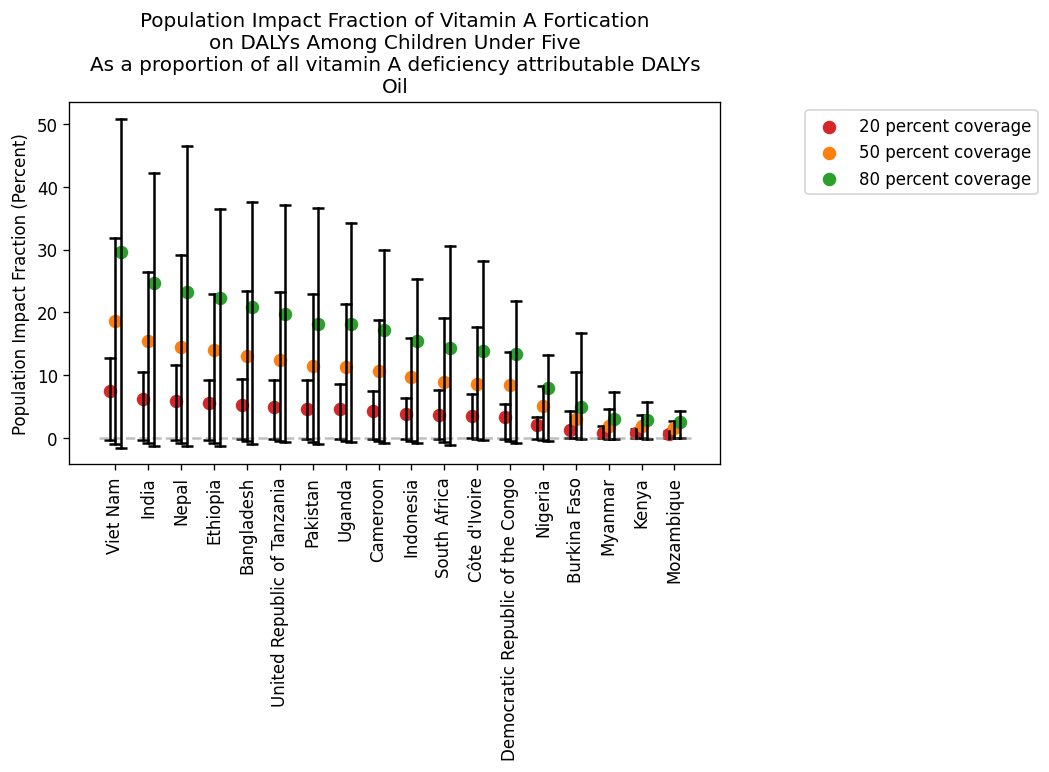

In [20]:
make_dot_plots(vitamin_a_daly_reduction_counts, 'Vitamin A', 'counts', coverage_levels, 'Oil', 'vitamin_a_u5_counts_averted')
make_dot_plots(vitamin_a_daly_reduction_rates, 'Vitamin A', 'rates', coverage_levels, 'Oil', 'vitamin_a_u5_rates_averted')
make_dot_plots(vitamin_a_overall_pifs, 'Vitamin A', 'pifs', coverage_levels, 
               'As a proportion of all vitamin A deficiency attributable DALYs\nOil',
              'vitamin_a_u5_pif')

# ZINC

In [21]:
# ZINC
rei_id = 97
nutrient = 'zinc'
vehicles = ['wheat flour','maize flour']
effective_fractions = [0,0,0,1]

In [22]:
# define no fortification relative risk distribution
# vitamin a specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 0.47
q_975 = 0.69

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

# Frozen lognormal distribution for RR, representing uncertainty in our effect size
# (s is the shape parameter)
rr_distribution = lognorm(s=sigma, scale=median)

In [23]:
zinc_baseline_coverage, zinc_counterfactual_coverage = get_baseline_and_counterfactual_coverage(coverage_data_dir,
                                             location_ids,
                                             'zinc',
                                             ['wheat flour','maize flour'],
                                             years,
                                             coverage_levels)

Excluded [11]/zinc/wheat flour due to impossible logical values
Excluded [205]/zinc/maize flour due to impossible logical values


In [25]:
zinc_rr_deficiency_nofort = (1 / generate_rr_deficiency_nofort_draws(mu, sigma, location_ids))
zinc_rr_deficiency_nofort.mean(axis=1)

location_id
161    2.178029
201    2.178029
202    2.178029
205    2.178029
171    2.178029
179    2.178029
163    2.178029
11     2.178029
180    2.178029
184    2.178029
15     2.178029
164    2.178029
214    2.178029
165    2.178029
196    2.178029
190    2.178029
189    2.178029
20     2.178029
dtype: float64

In [26]:
zinc_dalys_hdf_key = '/zinc_deficiency/dalys_attributable_bmgf_25_countries'
try:
    zinc_dalys = pd.read_hdf(gbd_data_filepath, key=zinc_dalys_hdf_key)
except (FileNotFoundError, KeyError) as e:
    print(e, "Calling get_draws...")
    zinc_dalys = pull_deficiency_attributable_dalys(rei_id,
                                              location_ids,
                                              age_group_ids,
                                              sex_ids,
                                              index_cols)
else:
    # Stored data included all 25 locations, so filter to desired locations if try clause succeeded
    zinc_dalys = zinc_dalys.query("location_id in @location_ids")

zinc_dalys.head()

draw_0      draw_1     draw_10  \
location_id sex_id age_group_id                                        
11          1      5             1057.924493  369.707946  517.346114   
            2      5              954.532812  197.702087  436.339271   
15          1      5              313.163965   18.266017   79.234558   
            2      5              191.677001   12.352737   50.662059   
20          1      5               48.242884    2.459229   19.265943   

                                    draw_100    draw_101    draw_102  \
location_id sex_id age_group_id                                        
11          1      5             1121.865646  383.960301  326.811523   
            2      5             1209.191167  371.705455  208.350528   
15          1      5              128.724069   27.397756   42.252433   
            2      5               88.065378   16.415385   25.701953   
20          1      5               52.284870   10.616299   10.393659   

                                   draw_103     draw_104     draw_105  \
location_id sex_id age_group_id                                         
11          1      5             290.876450  1234.791858  1980.744828   
            2      5             464.778852  1270.639991  1371.653872   
15          1      5              45.034578   168.170188   167.670791   
            2      5              32.398456   214.882244   224.620248   
20          1      5              12.405497    49.169895    64.661551   

                                   draw_106  ...     draw_990     draw_991  \
location_id sex_id age_group_id              ...                             
11          1      5             928.505912  ...  1295.128773  2676.259203   
            2      5             665.427560  ...  1074.683581  2096.088331   
15          1      5             189.359412  ...   132.672371   285.220362   
            2      5              59.568140  ...    97.337436   153.330263   
20          1      5              22.958977  ...    72.421762   124.529588   

                                    draw_992     draw_993     draw_994  \
location_id sex_id age_group_id                                          
11          1      5             1164.434543  1504.802755  3333.240053   
            2      5              897.944516   993.337161  2816.770108   
15          1      5              102.390704   220.484294   547.323432   
            2      5               70.591128   137.252187   339.566706   
20          1      5               36.856869    57.714761   189.540112   

                                    draw_995     draw_996     draw_997  \
location_id sex_id age_group_id                                          
11          1      5             2298.076536  1813.060392  1378.863465   
            2      5             2380.433080  1282.128241   957.580283   
15          1      5              387.181049   198.262244    86.842222   
            2      5              216.491836    73.747575    73.569971   
20          1      5              166.677178    53.183620    45.270356   

                                    draw_998     draw_999  
location_id sex_id age_group_id                            
11          1      5             1424.566740  1897.192422  
            2      5             1063.576027  1460.532078  
15          1      5              112.237688   146.724520  
            2      5               90.659169   156.583992  
20          1      5               40.578213    81.721393  

[5 rows x 1000 columns]

In [27]:
zinc_baseline_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_baseline_coverage.set_index([c for c in zinc_baseline_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)
zinc_counterfactual_effective_coverage = apply_age_related_effective_coverage_restrictions(
                                                                zinc_counterfactual_coverage.set_index([c for c in zinc_counterfactual_coverage.columns if 'draw' not in c]),
                                                                sex_ids,
                                                                age_group_ids,
                                                                effective_fractions)

In [28]:
zinc_paf_deficiency_nofort = calculate_paf_deficiency_nofort(
                                    zinc_rr_deficiency_nofort, 
                                    zinc_baseline_effective_coverage)
zinc_paf_deficiency_nofort.head()

draws                                               draw_0    draw_1  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.345476  0.571001   
                                2022 wheat flour  0.345476  0.571001   
                                2023 wheat flour  0.345476  0.571001   
                                2024 wheat flour  0.345476  0.571001   
                                2025 wheat flour  0.345476  0.571001   

draws                                              draw_10  draw_100  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.584197  0.603221   
                                2022 wheat flour  0.584197  0.603221   
                                2023 wheat flour  0.584197  0.603221   
                                2024 wheat flour  0.584197  0.603221   
                                2025 wheat flour  0.584197  0.603221   

draws                                             draw_101  draw_102  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.494235   0.49253   
                                2022 wheat flour  0.494235   0.49253   
                                2023 wheat flour  0.494235   0.49253   
                                2024 wheat flour  0.494235   0.49253   
                                2025 wheat flour  0.494235   0.49253   

draws                                             draw_103  draw_104  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.645743  0.483019   
                                2022 wheat flour  0.645743  0.483019   
                                2023 wheat flour  0.645743  0.483019   
                                2024 wheat flour  0.645743  0.483019   
                                2025 wheat flour  0.645743  0.483019   

draws                                             draw_105  draw_106  ...  \
location_id age_group_id sex_id year vehicle                          ...   
15          2            1      2021 wheat flour  0.579614  0.378442  ...   
                                2022 wheat flour  0.579614  0.378442  ...   
                                2023 wheat flour  0.579614  0.378442  ...   
                                2024 wheat flour  0.579614  0.378442  ...   
                                2025 wheat flour  0.579614  0.378442  ...   

draws                                             draw_990  draw_991  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.548122  0.568194   
                                2022 wheat flour  0.548122  0.568194   
                                2023 wheat flour  0.548122  0.568194   
                                2024 wheat flour  0.548122  0.568194   
                                2025 wheat flour  0.548122  0.568194   

draws                                             draw_992  draw_993  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.399642   0.34575   
                                2022 wheat flour  0.399642   0.34575   
                                2023 wheat flour  0.399642   0.34575   
                                2024 wheat flour  0.399642   0.34575   
                                2025 wheat flour  0.399642   0.34575   

draws                                             draw_994  draw_995  \
location_id age_group_id sex_id year vehicle                           
15          2            1      2021 wheat flour  0.587321  0.526427   
                                2022 wheat flour  0.587321  0.526427   
                                2023 wheat flour  0.587321  0.526427   
                                2024 wheat flour  0.587321  0.526427  

In [29]:
zinc_pif_deficiency_nofort = calculate_pif_deficiency_nofort(
                                    zinc_paf_deficiency_nofort,
                                    zinc_baseline_effective_coverage,
                                    zinc_counterfactual_effective_coverage)
zinc_pif_deficiency_nofort.head()

draws                                                            draw_0  \
location_id age_group_id sex_id year vehicle     coverage_level           
15          2            1      2021 wheat flour 0.2                0.0   
                                                 0.5                0.0   
                                                 0.8                0.0   
                                2022 wheat flour 0.2                0.0   
                                                 0.5                0.0   

draws                                                            draw_1  \
location_id age_group_id sex_id year vehicle     coverage_level           
15          2            1      2021 wheat flour 0.2                0.0   
                                                 0.5                0.0   
                                                 0.8                0.0   
                                2022 wheat flour 0.2                0.0   
                                                 0.5                0.0   

draws                                                            draw_10  \
location_id age_group_id sex_id year vehicle     coverage_level            
15          2            1      2021 wheat flour 0.2                 0.0   
                                                 0.5                 0.0   
                                                 0.8                 0.0   
                                2022 wheat flour 0.2                 0.0   
                                                 0.5                 0.0   

draws                                                            draw_100  \
location_id age_group_id sex_id year vehicle     coverage_level             
15          2            1      2021 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                2022 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_101  \
location_id age_group_id sex_id year vehicle     coverage_level             
15          2            1      2021 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                2022 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_102  \
location_id age_group_id sex_id year vehicle     coverage_level             
15          2            1      2021 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                2022 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_103  \
location_id age_group_id sex_id year vehicle     coverage_level             
15          2            1      2021 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   
                                                 0.8                  0.0   
                                2022 wheat flour 0.2                  0.0   
                                                 0.5                  0.0   

draws                                                            draw_104  \
location_id age_group_id sex_id year vehicle     coverage_level             
15          2            1      2021 wheat flour 0.2                  0.0   
                        

In [30]:
zinc_overall_pifs, zinc_daly_reduction_counts = calculate_final_pifs_and_daly_reductions(
                                                    zinc_pif_deficiency_nofort,
                                                    zinc_dalys,
                                                    coverage_levels, years)

In [31]:
zinc_daly_reduction_rates = calculate_rates(zinc_daly_reduction_counts, 
                                            location_ids, 
                                            age_group_ids, 
                                            sex_ids)

In [32]:
zinc_overall_pifs['measure'] = 'pif'
zinc_daly_reduction_counts['measure'] = 'counts_averted'
zinc_daly_reduction_rates['measure'] = 'rates_averted'
zinc_results = pd.concat([zinc_overall_pifs.reset_index(),
                         zinc_daly_reduction_counts.reset_index(),
                         zinc_daly_reduction_rates.reset_index()],
                        ignore_index=True)
zinc_results.to_pickle('results_raw/zinc.pkl')

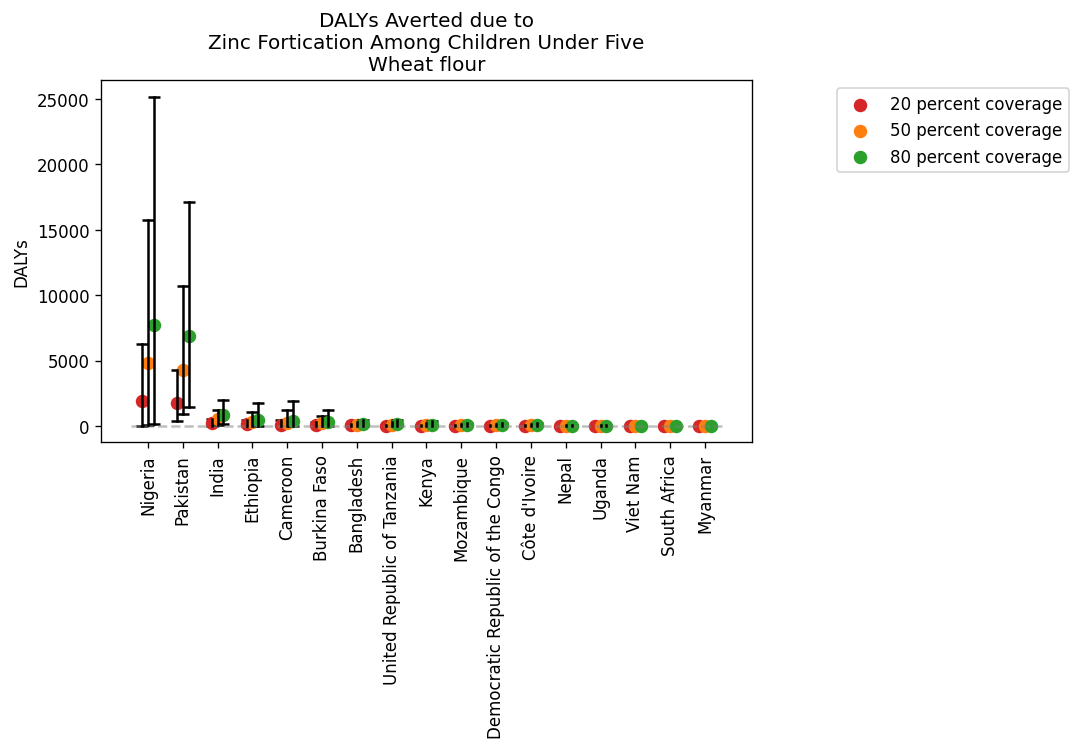

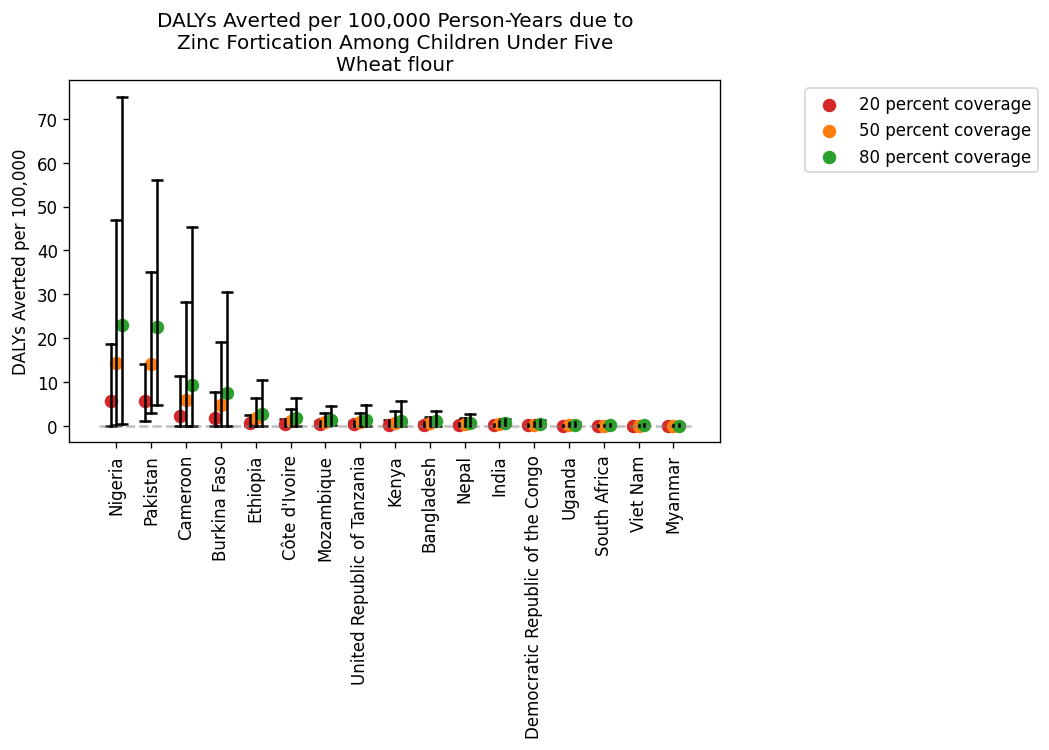

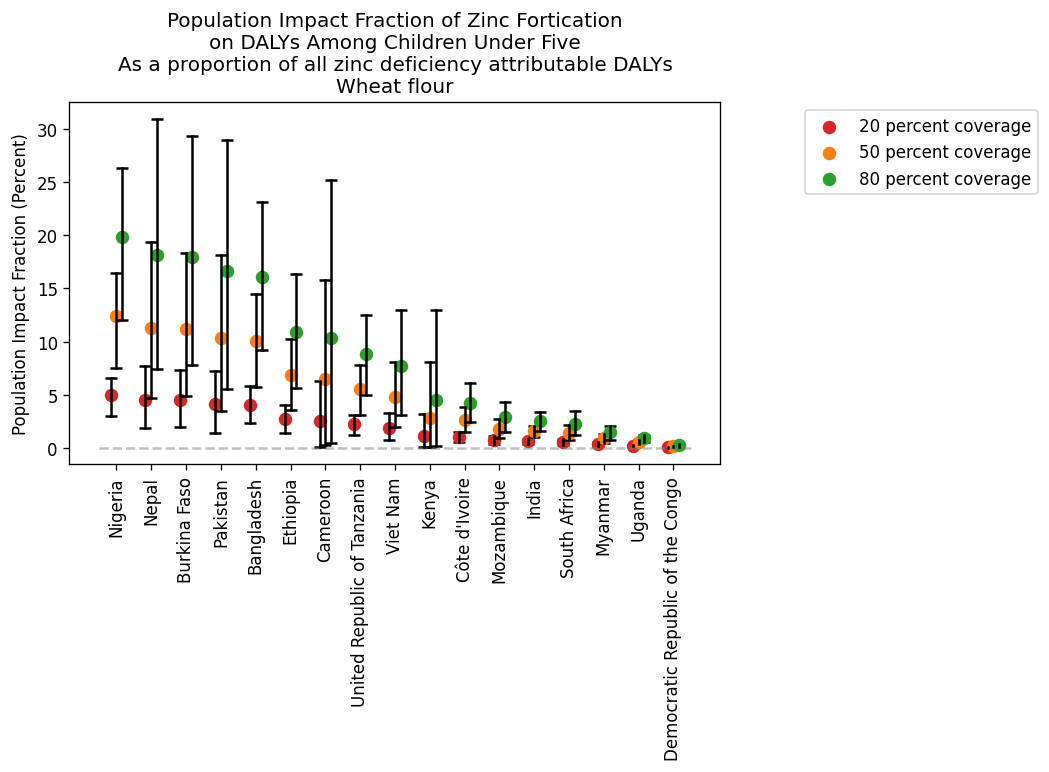

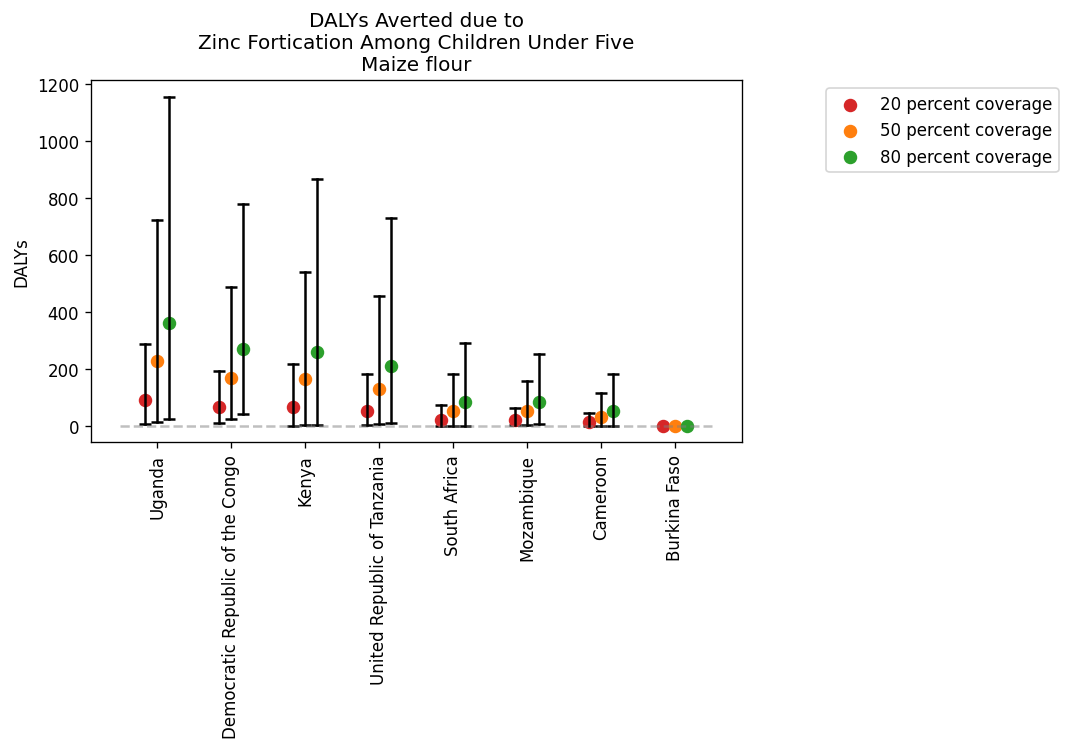

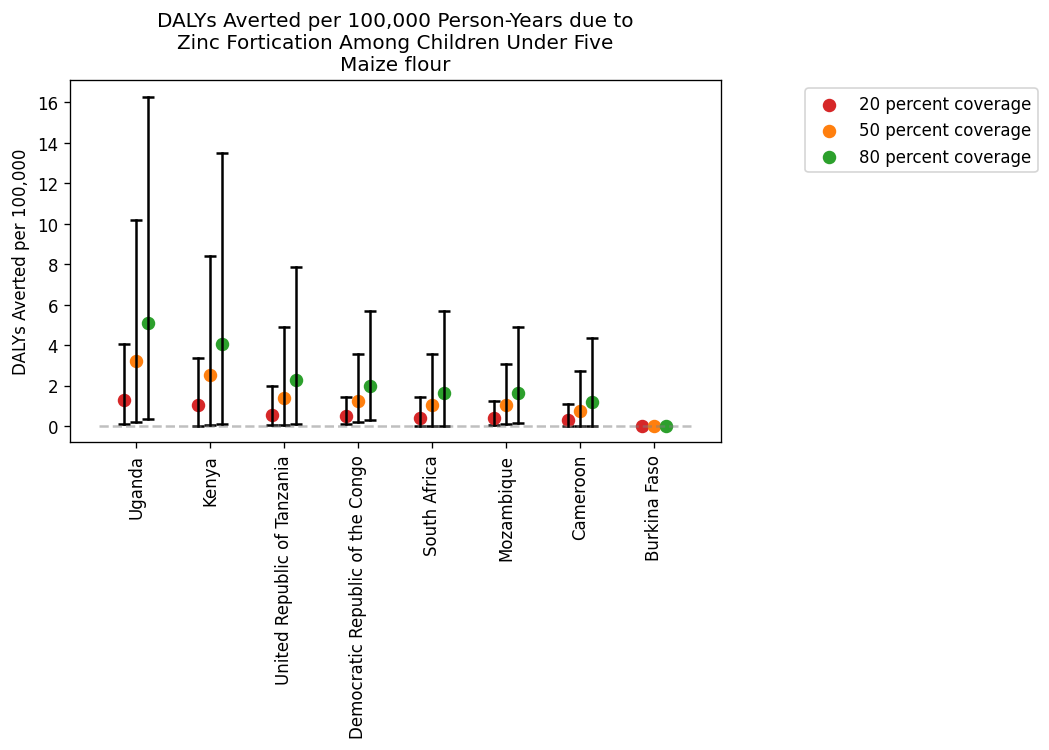

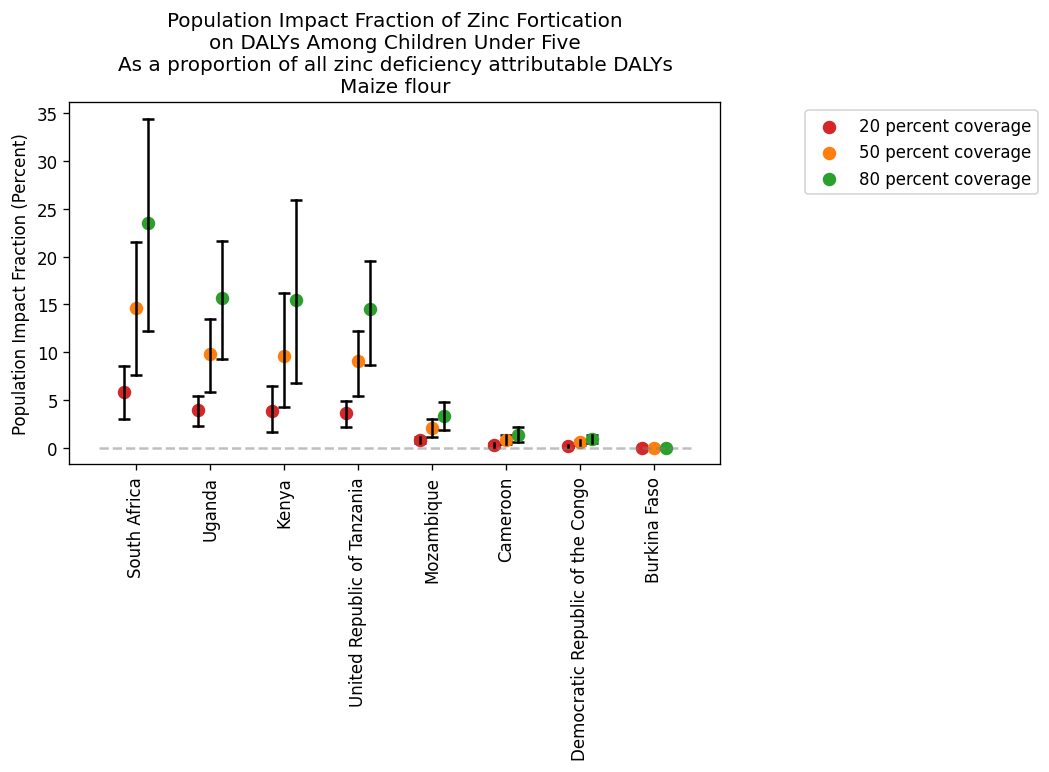

In [33]:
for vehicle in ['wheat flour','maize flour']:
    make_dot_plots((zinc_daly_reduction_counts.reset_index()
                .loc[zinc_daly_reduction_counts.reset_index().vehicle==vehicle]
                .set_index([c for c in zinc_daly_reduction_counts.reset_index() if 'draw' not in c])), 
               'Zinc', 'counts', coverage_levels,f'{vehicle.capitalize()}', f'zinc_u5_counts_averted_{vehicle}')
    make_dot_plots((zinc_daly_reduction_rates.reset_index()
                .loc[zinc_daly_reduction_rates.reset_index().vehicle==vehicle]
                .set_index([c for c in zinc_daly_reduction_rates.reset_index() if 'draw' not in c])), 
               'Zinc', 'rates', coverage_levels,f'{vehicle.capitalize()}', f'zinc_u5_rates_averted_{vehicle}')
    make_dot_plots((zinc_overall_pifs.reset_index()
                .loc[zinc_overall_pifs.reset_index().vehicle==vehicle]
                .set_index([c for c in zinc_overall_pifs.reset_index() if 'draw' not in c])), 
               'Zinc', 'pifs', coverage_levels,
                   f'As a proportion of all zinc deficiency attributable DALYs\n{vehicle.capitalize()}', 
                   f'zinc_u5_pif_{vehicle}')